In [1]:
from distinctipy import colorsets
colorsets.set_palette()

import pandas as pd
import ipywidgets as widgets
from IPython.display import clear_output

from wimbledon.vis import Visualise

## Select Dates to Show

In [2]:
# date picker to choose a start date
widg_start = widgets.DatePicker(
                    description='Start Date:',
                    value=pd.datetime.now() - pd.Timedelta('365 days'),
                    disabled=False)

# date picker to choose an end date
widg_end = widgets.DatePicker(
                    description='End Date:',
                    value=pd.datetime.now(),
                    disabled=False)

freq_dict = {'Monthly':'MS','Weekly':'W-MON','Daily':'D'}

# radio buttons to choose the frequency of dates to display in the table
widg_freq = widgets.RadioButtons(
    options=freq_dict.keys(),
    description='Frequency:',
    disabled=False)

display(widg_start, widg_end, widg_freq)

DatePicker(value=datetime.datetime(2018, 8, 22, 14, 35, 13, 695243), description='Start Date:')

DatePicker(value=datetime.datetime(2019, 8, 22, 14, 35, 13, 699110), description='End Date:')

RadioButtons(description='Frequency:', options=('Monthly', 'Weekly', 'Daily'), value='Monthly')

## Initialise Visualisation Object

In [3]:
# set true if you want to query the Harvest API and update the database
# with the latest data (slow for time entries!)
# set false if you're happy with the current status of the database and
# don't want to wait for the update.
update_db = True

vis = Visualise(start_date=pd.to_datetime(widg_start.value), 
                end_date=pd.to_datetime(widg_end.value), 
                freq=freq_dict[widg_freq.value],
                update_db=update_db)

In [4]:
def update_vis_params(change):
    vis.START_DATE = pd.to_datetime(widg_start.value)
    vis.END_DATE = pd.to_datetime(widg_end.value)
    vis.FREQ = freq_dict[widg_freq.value]

widg_start.observe(update_vis_params, names='value')
widg_end.observe(update_vis_params, names='value')
widg_freq.observe(update_vis_params, names='value')

## Compare Scheduled Time in Forecast to Tracked Time in Harvest

Dropdown(description='Project:', index=57, options=('44 days', 'AI for City Planning', 'AIDA', 'AIDA Wrangling…

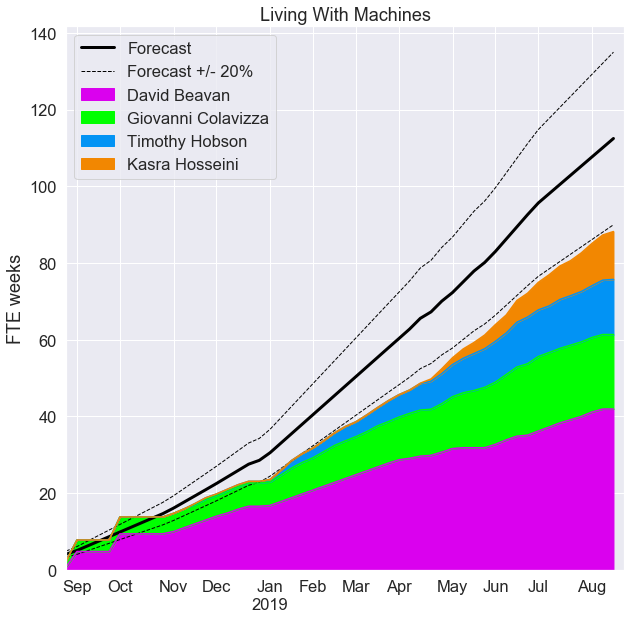

In [7]:
## dropdown list to select a project
widg_project_select = widgets.Dropdown(options=sorted([vis.wim.get_project_name(project_id) for project_id in vis.wim.projects.index]),
                                 description='Project:')


widg_stack_checkbox = widgets.Checkbox(value=True, description='Show People?')
widg_err_checkbox = widgets.Checkbox(value=True, description='Show Error?')
widg_err_size = widgets.FloatSlider(value=0.2, min=0, max=0.5, step=0.01,
                                    description='Error size:',
                                    orientation='horizontal',
                                    continuous_update=False,
                                    readout=True,
                                    readout_format='.0%')

def widg_change(change):
    """Function called by widgets to update the project allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_project_select, 
            widgets.HBox([widg_stack_checkbox, widg_err_checkbox, widg_err_size]))
    
    # get the project_id from the selected full name (need to first split into first and last names)
    project_id = vis.wim.get_project_id(widg_project_select.value)
    
    # plot the harvest vs forecast comparison
    vis.plot_forecast_harvest(project_id, 
                              stack=widg_stack_checkbox.value,
                              err_bar=widg_err_checkbox.value,
                              err_size=widg_err_size.value,
                              units='FTE weeks')

# setup the event listeners
widg_project_select.observe(widg_change, names='value')
widg_stack_checkbox.observe(widg_change, names='value')
widg_err_checkbox.observe(widg_change, names='value')
widg_err_size.observe(widg_change, names='value')

# display the widgets
display(widg_project_select, 
        widgets.HBox([widg_stack_checkbox, widg_err_checkbox, widg_err_size]))

# show results with initial values
widg_change(None)

## Plot Tracked Time with Different Groupings/Styles

Dropdown(description='id_value:', options=('44 days', 'AI for City Planning', 'AIDA', 'AIDA Wrangling', 'AIDA-…

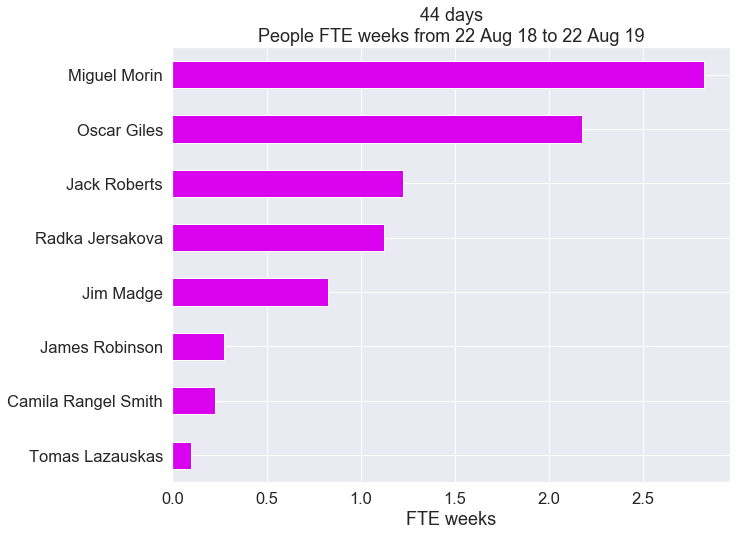

In [6]:
# TODO: Fix nasty errors in cases where there's nothing to plot

group_dict = {'project': ['person', 'task', 'TOTAL'],
              'person': ['project', 'client', 'task', 'TOTAL'],
              'client': ['TOTAL'],
              'task': ['TOTAL']}

widg_id_type = widgets.Dropdown(options=group_dict.keys(), description='id_type:')


widg_group_type = widgets.Dropdown(options=group_dict[widg_id_type.value],
                                 description='group_type:')

widg_id_value = widgets.Dropdown(options=sorted(vis.wim.projects['name']), 
                                 description='id_value:')

widg_plot_type = widgets.RadioButtons(options=['bar', 'heatmap', 'pie'],
                                      description='Plot type:')

widg_update_button = widgets.Button(description='Update plot')

def widg_harvest_update(change):
    """Function called by widgets to update the project allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    # display the widgets
    display(widgets.HBox([widg_id_type, widg_group_type]), widg_id_value, widgets.HBox([widg_plot_type, widg_update_button]))
    
    # get the id from the selected type and value
    id_value = vis.wim.get_id(widg_id_value.value, widg_id_type.value)

    try:
        vis.plot_harvest(widg_id_type.value, 
                         widg_group_type.value,
                         id_value=id_value,
                         plot_type = widg_plot_type.value,
                         units = 'FTE weeks')
    except:
        print('No data to plot')
    
def widg_update_groups(change):
    widg_group_type.options = group_dict[widg_id_type.value]            
    
def widg_update_ids(change):
    if widg_id_type.value=='person':
        widg_id_value.options = sorted(vis.wim.people['name'])
    elif widg_id_type.value=='project':
        widg_id_value.options = sorted(vis.wim.projects['name'])
    elif widg_id_type.value=='client':
        widg_id_value.options = sorted(vis.wim.clients['name'])
    elif widg_id_type.value=='task':
        widg_id_value.options = sorted(vis.wim.tasks['name'])

def widg_update_id_type(change):
    widg_update_ids(change)
    widg_update_groups(change)
    
# setup the event listeners
widg_id_type.observe(widg_update_id_type, names='value')
widg_update_button.on_click(widg_harvest_update)

# display the widgets
display(widgets.HBox([widg_id_type, widg_group_type]), widg_id_value, widgets.HBox([widg_plot_type, widg_update_button]))

# show results with initial values
widg_harvest_update(None)